In [1]:
import sys
sys.path.insert(0, './py_torch_trpo')
from agent_file import agent
import gym
import scipy.optimize
import roboschool
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace", font_scale=2)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('seaborn-white')
from baselines.common import set_global_seeds, tf_util as U
from baselines import bench
import gym, logging
import roboschool
from baselines import logger
from baselines.ppo1 import mlp_policy, pposgd_simple
from base_line_model.mlp import MlpPolicy_new
from base_line_model.PPO_agent import learning_agent
sns.set(context = "paper", font = "monospace", font_scale=2)

In [2]:
env = gym.make("RoboschoolHopper-v1")
env.seed(0)
np.random.seed(0)
seed = 1
logger.configure()
U.make_session(num_cpu=16).__enter__()
set_global_seeds(seed)

[2018-04-14 21:43:23,837] Making new env: RoboschoolHopper-v1


Logging to /tmp/openai-2018-04-14-21-43-23-844071


In [3]:
env2 = gym.make('RoboschoolHopper-v1')
env2 = bench.Monitor(env2, logger.get_dir(),allow_early_resets=True)
env2.seed(seed)
gym.logger.setLevel(logging.WARN)
class pargm(object):
    def __init__(self):
        self.timesteps_per_actorbatch = 25000#25000 # timesteps per actor per update
        self.clip_param = 0.2 
        self.entcoeff = 0.0 # clipping parameter epsilon, entropy coeff
        self.optim_epochs = 10 
        self.optim_stepsize = 3e-4
        self.optim_batchsize = 64# optimization hypers
        self.gamma = 0.99
        self.lam = 0.95 # advantage estimation
        self.max_timesteps=10e8#1e10 
        self.max_episodes=0 
        self.max_iters=0 
        self.max_seconds=0  # time constraint
        self.callback=None # you can do anything in the callback, since it takes locals(), globals()
        self.adam_epsilon=1e-5
        self.schedule='linear' # annealing for stepsize parameters (epsilon and adam)


def policy_fn(name, ob_space, ac_space):
        return MlpPolicy_new(name=name, ob_space=ob_space, ac_space=ac_space,
            hid_size=64, num_hid_layers=2)
    
parg = pargm()
agent2 = learning_agent('pi2', env2, policy_fn, parg)
agent2.restore('hopper_mem')

[2018-04-14 21:43:23,885] Making new env: RoboschoolHopper-v1


INFO:tensorflow:Restoring parameters from hopper_mem/data


[2018-04-14 21:43:24,579] Restoring parameters from hopper_mem/data


In [4]:
class action_space(object):
    def __init__(self, env):
        self.env = env
        self.high = np.array([ 1,  1,  1,  1,  1])
        self.low = -np.array([ 1,  1,  1,  1,  1])
        self.shape = env.observation_space.shape
    
    def sample(self):
    
        return self.env.observation_space.sample()
        
        
class adversial_env(object):
    def __init__(self,ag):
        # parameter
        self.env = gym.make("RoboschoolHopper-v1")
        self.env.seed(0)
        self.ratio = 0.15
        self.threshold = np.array([ 0.13563991,  0.        ,  0.        ,  0.63022727,  0.        ,
        0.4455283 ,  0.        ,  0.10436863,  0.08628476,  0.22765335,
        0.17268705,  0.29754525,  0.64068675,  0.65350312,  0.49892119])
        self.max_turn = 1000
        self.combine_ratio = 0.05
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.env.observation_space.shape[0],))
        self.observation_space = self.env.observation_space
        self.agent = ag
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
        self.env.metadata
    
    # define reward function
    def reward(self, st):
        return np.abs(st[3])+0.2*np.abs(st[1])-0.08
    
    def step(self, a):
        self.epi_num = self.epi_num + 1
        
        obs = np.clip(a,-1,1)*self.threshold*self.ratio + self.obsr
        
        ac = self.agent.action_ev(obs)
        self.obsr, r, done, _ = self.env.step(ac)
        #print( np.clip(a,-1,1),np.clip(a,-1,1)*self.ratio)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done: ###################################
            self.first = False
            self.run_avg = self.total_score
            self.score_list = [self.total_score]
            self.epi_list = [self.epi_num]
            print(self.run_avg, self.score_list, self.epi_list)
            
        
        final_r = -r
        if done and self.epi_num < self.max_turn:
            final_r = 15 # terminal cost 
        
        self.total_score += final_r
        return self.obsr, final_r, done, 0
        
        
    def seed(self, a):
        pass
    
    def reset(self):
        self.obsr = self.env.reset()
        #print(self.total_score)
        self.run_avg = (self.combine_ratio*self.total_score) + (1-self.combine_ratio)*self.run_avg
        #print(self.run_avg)
        #print(self.epi_num)
        
        if not self.first: #########################################
            self.rvg_list.append(self.run_avg)
            self.score_list.append(self.total_score)
            self.epi_list.append(self.epi_num)
        
        self.epi_num = 0
        self.total_score = 0
        return self.obsr
    
    def result_plot(self):
        fon_size = 19
        x = list(range(0, len(self.score_list[1:])))
        fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1,2,1)
        plt.scatter(x,self.score_list[1:], s=5)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('cumulative reward',fontsize=fon_size)
        plt.ylim([-3000,0])
        #plt.subplot(1,3,2)
        #plt.plot(self.rvg_list[1:])
        #plt.xlabel('episodes')
        #plt.ylabel('running average reward')
        plt.subplot(1,2,2)
        x = list(range(0, len(self.epi_list)))
        plt.scatter(x,self.epi_list, s=5)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('time steps',fontsize=fon_size)
        plt.ylim([0,1200])
        plt.show()

# Define an adversarial

In [5]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 25000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = -235
        
args = par()
env = adversial_env(agent2)
agn = agent(env, args)
#agn.load_model('agent_model/adversarial_agent2_distr')

# Agent training

In [6]:
agn.learn()

-2813.4278429245423 [-2813.4278429245423] [1000]
Episode 0	Last reward: -2825.615991658672	Average reward -2703.42
('lagrange multiplier:', 0.5212478873155442, 'grad_norm:', 0.06327233488207352)
fval before -2.611099270394699e-15
a/e/r 0.010974935934870114 0.01042495774631135 1.0527559153660226
fval after -0.010974935934872724
Episode 1	Last reward: -2800.7322034932977	Average reward -2761.28
('lagrange multiplier:', 0.4389285261564764, 'grad_norm:', 0.05652261719907347)
fval before 1.0456087028612022e-16
a/e/r 0.008891593462208087 0.008778570523129402 1.0128748682693722
fval after -0.008891593462207983
Episode 2	Last reward: -2810.8296108746017	Average reward -2644.18
('lagrange multiplier:', 0.4625458290796289, 'grad_norm:', 0.0653428176490899)
fval before -1.0096980581420287e-16
a/e/r 0.009436964979643973 0.009250916581592543 1.0201113474984336
fval after -0.009436964979644073
Episode 3	Last reward: -2802.1470194454696	Average reward -2568.27
('lagrange multiplier:', 0.4521669972142

Episode 29	Last reward: -2810.640300753166	Average reward -2686.64
('lagrange multiplier:', 0.5300060246991904, 'grad_norm:', 0.07738379487740094)
fval before 2.9002727293430645e-17
a/e/r 0.010723836536650329 0.010600120493984216 1.0116711921092147
fval after -0.0107238365366503
Episode 30	Last reward: -2801.7674993205846	Average reward -2556.71
('lagrange multiplier:', 0.5055157936859028, 'grad_norm:', 0.07140808206674741)
fval before -2.454186386171945e-17
a/e/r 0.01032023882020997 0.010110315873718663 1.0207632431185452
fval after -0.010320238820209994
Episode 31	Last reward: -2806.0552919734446	Average reward -2464.43
('lagrange multiplier:', 0.5118853821420204, 'grad_norm:', 0.0754792005346712)
fval before -3.798349595667373e-17
a/e/r 0.01061038958780644 0.01023770764284015 1.0364028704440422
fval after -0.010610389587806478
Episode 32	Last reward: -2823.718861775586	Average reward -2476.07
('lagrange multiplier:', 0.4796612809872385, 'grad_norm:', 0.06732508896875838)
fval before

('lagrange multiplier:', 0.45344365866165576, 'grad_norm:', 0.06262389800389871)
fval before 2.0723587471128725e-17
a/e/r 0.009156065433324043 0.0090688731732329 1.0096144535738458
fval after -0.009156065433324022
Episode 59	Last reward: -2811.0325336625856	Average reward -2688.39
('lagrange multiplier:', 0.4831688349176075, 'grad_norm:', 0.06722956187819765)
fval before 3.482579825926259e-17
a/e/r 0.009785995206480812 0.009663376698352153 1.0126889918458388
fval after -0.009785995206480777
Episode 60	Last reward: -2850.275825948806	Average reward -2703.03
('lagrange multiplier:', 0.4842821626861979, 'grad_norm:', 0.07691333187839332)
fval before 5.884156313046926e-17
a/e/r 0.009973648120398948 0.009685643253724091 1.0297352338022692
fval after -0.009973648120398889
Episode 61	Last reward: -2793.172478620735	Average reward -2681.38
('lagrange multiplier:', 0.5099953367814142, 'grad_norm:', 0.07555168009213187)
fval before -4.2000284008027043e-17
a/e/r 0.010422839523232608 0.01019990673

fval before 6.903848985200626e-18
a/e/r 0.010022913569055108 0.0098473128425073 1.017832349734011
fval after -0.010022913569055101
Episode 88	Last reward: -2815.8387870871506	Average reward -2481.03
('lagrange multiplier:', 0.4611033289706411, 'grad_norm:', 0.07226262751093998)
fval before -1.3638590587686034e-17
a/e/r 0.009545783292305293 0.00922206657941274 1.035102404662228
fval after -0.009545783292305307
Episode 89	Last reward: -2822.856139027562	Average reward -2446.91
('lagrange multiplier:', 0.5158418175115681, 'grad_norm:', 0.08994823758910228)
fval before -2.854884319517464e-17
a/e/r 0.010685587965972961 0.010316836350231411 1.0357427028231652
fval after -0.010685587965972989
Episode 90	Last reward: -2827.6380956636294	Average reward -2371.98
('lagrange multiplier:', 0.5308546537333975, 'grad_norm:', 0.08564657970708242)
fval before -1.5782044969992354e-18
a/e/r 0.0110900266998817 0.010617093074667535 1.0445445492366068
fval after -0.011090026699881702
Episode 91	Last reward:

Episode 117	Last reward: -1760.6987637003397	Average reward -2267.61
('lagrange multiplier:', 0.5377653971278454, 'grad_norm:', 0.08998305924873011)
fval before -3.1271592510377167e-16
a/e/r 0.010965796987124186 0.010755307942557427 1.0195707129624694
fval after -0.010965796987124498
Episode 118	Last reward: -2811.666954237277	Average reward -2167.96
('lagrange multiplier:', 0.4973060877921112, 'grad_norm:', 0.08078358996454527)
fval before 2.8369675294254543e-17
a/e/r 0.010028093993997947 0.009946121755845486 1.008241628261215
fval after -0.010028093993997919
Episode 119	Last reward: -2789.659111447398	Average reward -2373.00
('lagrange multiplier:', 0.5123431262832212, 'grad_norm:', 0.09011480969855586)
fval before -6.626375299133144e-18
a/e/r 0.010479219288511319 0.010246862525654812 1.0226758934527287
fval after -0.010479219288511326
Episode 120	Last reward: -2816.4847053004523	Average reward -2155.95
('lagrange multiplier:', 0.5243408434152171, 'grad_norm:', 0.08675079170269993)
f

('lagrange multiplier:', 0.6805834230576404, 'grad_norm:', 0.12965270218154953)
fval before 1.5481115788411278e-16
a/e/r 0.01380017221189808 0.013611668461153498 1.0138486880783613
fval after -0.013800172211897926
Episode 147	Last reward: -470.3851543614422	Average reward -737.30
('lagrange multiplier:', 0.6316324170368568, 'grad_norm:', 0.1050719371380904)
fval before -5.315023388828643e-17
a/e/r 0.012940708562640464 0.012632648340737091 1.024386036371325
fval after -0.012940708562640518
Episode 148	Last reward: -707.6662734202677	Average reward -724.70
('lagrange multiplier:', 0.6824872929281118, 'grad_norm:', 0.13502434686548448)
fval before 2.499943388495241e-16
a/e/r 0.013630725733705981 0.01364974585856302 0.9986065583158746
fval after -0.013630725733705731
Episode 149	Last reward: -831.135348198694	Average reward -637.60
('lagrange multiplier:', 0.6934415826983953, 'grad_norm:', 0.14093681233535443)
fval before 6.56329715788636e-16
a/e/r 0.0141495245721304 0.013868831653967694 1

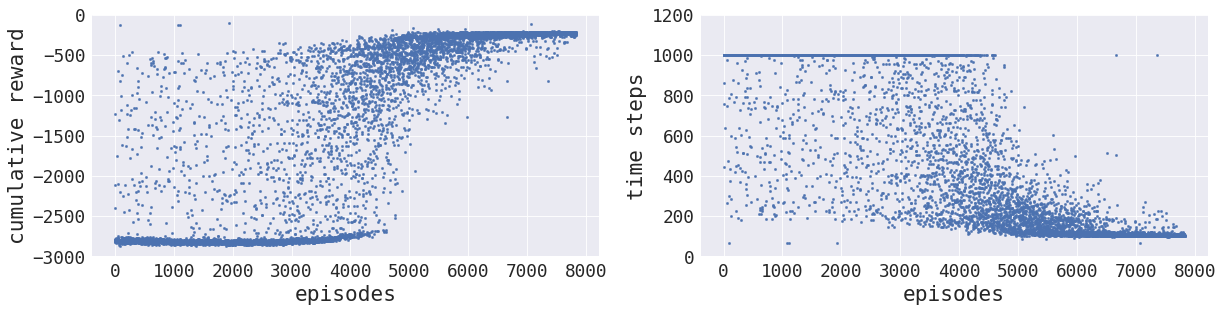

In [7]:
env.result_plot()

# Agent evaluation

In [8]:
env = adversial_env(agent2)
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    time = 0
    while done == False:   
        a = agn.select_action_deterministic(obs)
        time +=1
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

-227.51167475055556 [-227.51167475055556] [100]


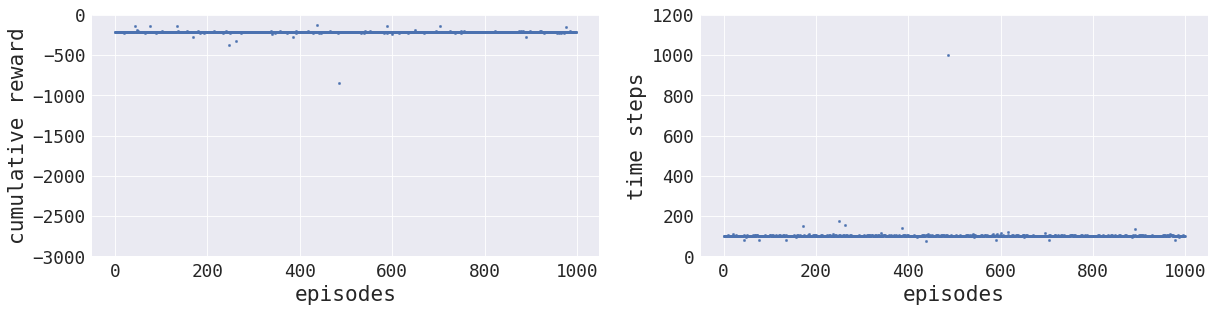

In [9]:
env.result_plot()

# Save model

In [10]:
agn.save_model('adv_agent_model/adversarial_agent2_distr')

# adversarial evaluation

In [11]:
import gym
import scipy.optimize
import roboschool
from agent_file import agent
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace", font_scale=2)

In [12]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 15000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 55
        
args = par()
env = adversial_env(agent2)
agn = agent(env, args)
agn.load_model('adv_agent_model/adversarial_agent2_distr')

In [13]:
thres = np.array([ 0.13563991,  0.        ,  0.        ,  0.63022727,  0.        ,
        0.4455283 ,  0.        ,  0.10436863,  0.08628476,  0.22765335,
        0.17268705,  0.29754525,  0.64068675,  0.65350312,  0.49892119])

In [14]:
env = adversial_env(agent2)
action = []
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    time = 0
    while done == False:   
        a = agn.select_action_deterministic(obs)
        action.append(np.clip(a,-1,1)*thres*0.15)
        time +=1
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

-227.51167475055556 [-227.51167475055556] [100]


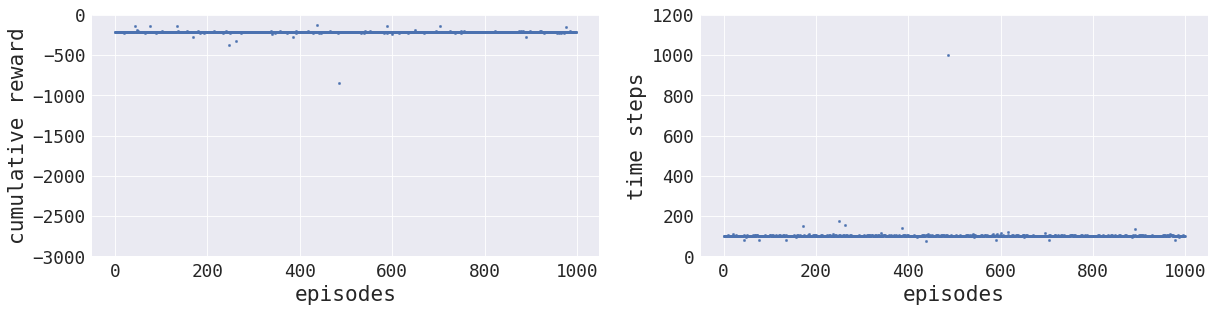

In [15]:
env.result_plot()

In [16]:
np.array(action)

array([[-0.01114936,  0.        ,  0.        , ..., -0.05183545,
        -0.0234227 , -0.02989796],
       [-0.01024545,  0.        ,  0.        , ..., -0.02302335,
        -0.00747188, -0.0180778 ],
       [-0.01173278,  0.        ,  0.        , ..., -0.02369148,
        -0.01055019, -0.01445846],
       ..., 
       [ 0.01407609,  0.        ,  0.        , ..., -0.04757666,
        -0.09802547, -0.02274352],
       [ 0.0153296 ,  0.        ,  0.        , ..., -0.04343312,
        -0.09802547, -0.02024676],
       [ 0.01676075,  0.        ,  0.        , ..., -0.04080911,
        -0.09802547, -0.01855195]])

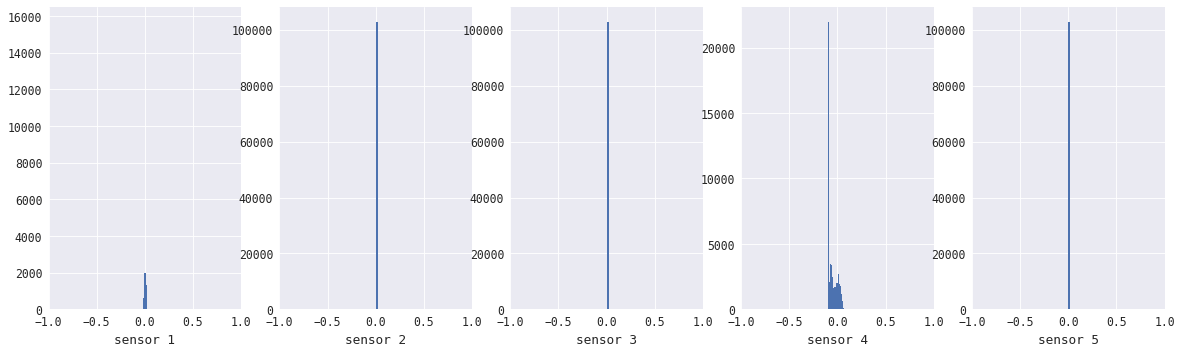

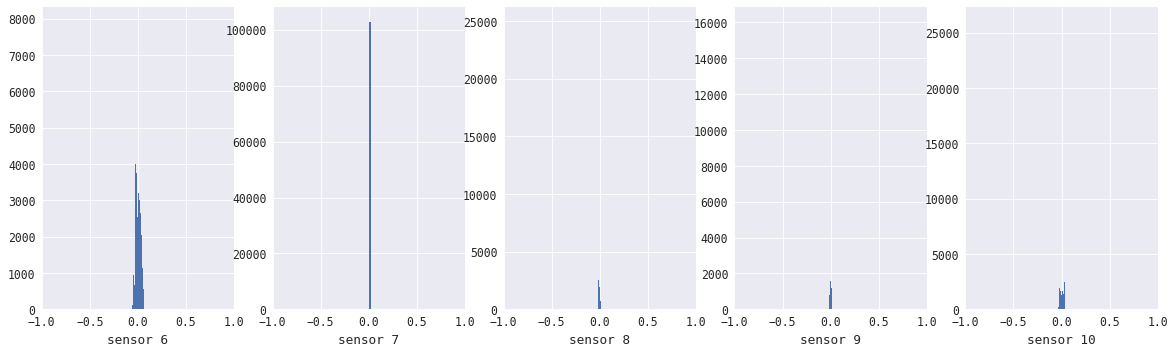

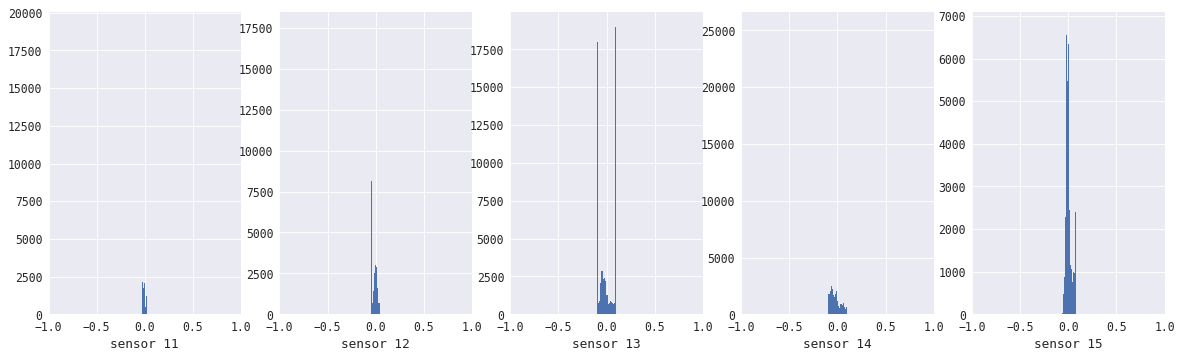

In [17]:
bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,0], bins = bin_num)
plt.xlim(-1,1)
plt.xlabel('sensor 1')

plt.subplot(1,5,2)
plt.hist(sensor_array[:,1], bins = bin_num)
plt.xlim(-1,1)
plt.xlabel('sensor 2')

plt.subplot(1,5,3)
plt.hist(sensor_array[:,2], bins = bin_num)
plt.xlim(-1,1)
plt.xlabel('sensor 3')

plt.subplot(1,5,4)
plt.hist(sensor_array[:,3], bins = bin_num)
plt.xlim(-1,1)
plt.xlabel('sensor 4')

plt.subplot(1,5,5)
plt.hist(sensor_array[:,4], bins = bin_num)
plt.xlim(-1,1)
plt.xlabel('sensor 5')

plt.show()


bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,5], bins = bin_num)
plt.xlim(-1,1)
plt.xlabel('sensor 6')

plt.subplot(1,5,2)
plt.hist(sensor_array[:,6], bins = bin_num)
plt.xlim(-1,1)
plt.xlabel('sensor 7')

plt.subplot(1,5,3)
plt.hist(sensor_array[:,7], bins = bin_num)
plt.xlim(-1,1)
plt.xlabel('sensor 8')

plt.subplot(1,5,4)
plt.hist(sensor_array[:,8], bins = bin_num)
plt.xlim(-1,1)
plt.xlabel('sensor 9')

plt.subplot(1,5,5)
plt.hist(sensor_array[:,9], bins = bin_num)
plt.xlim(-1,1)
plt.xlabel('sensor 10')

plt.show()
bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,10], bins = bin_num)
plt.xlim(-1,1)
plt.xlabel('sensor 11')

plt.subplot(1,5,2)
plt.hist(sensor_array[:,11], bins = bin_num)
plt.xlim(-1,1)
plt.xlabel('sensor 12')

plt.subplot(1,5,3)
plt.hist(sensor_array[:,12], bins = bin_num)
plt.xlim(-1,1)
plt.xlabel('sensor 13')

plt.subplot(1,5,4)
plt.hist(sensor_array[:,13], bins = bin_num)
plt.xlim(-1,1)
plt.xlabel('sensor 14')

plt.subplot(1,5,5)
plt.hist(sensor_array[:,14], bins = bin_num)
plt.xlim(-1,1)
plt.xlabel('sensor 15')

plt.show()

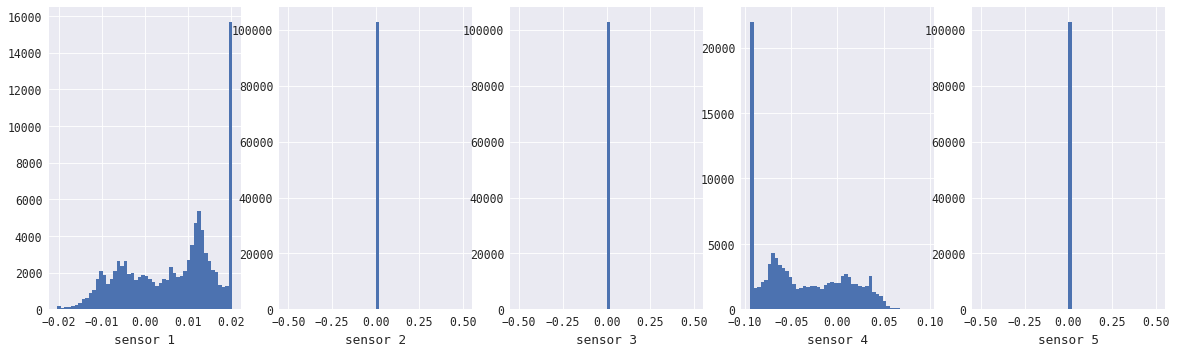

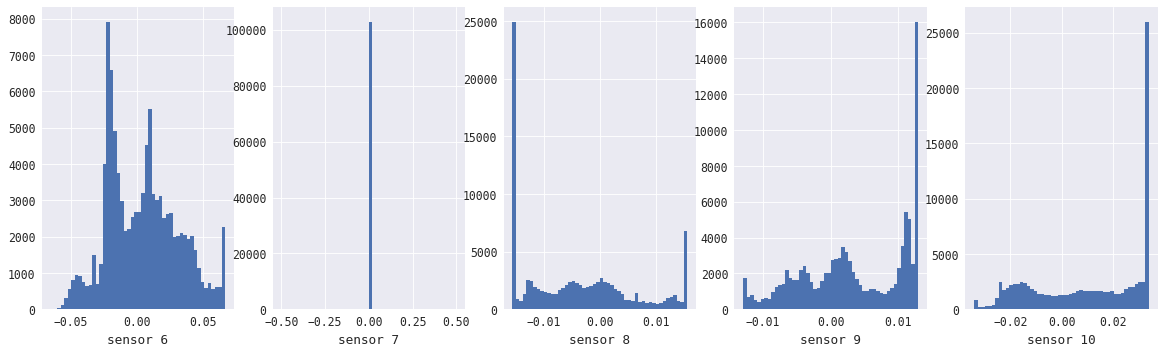

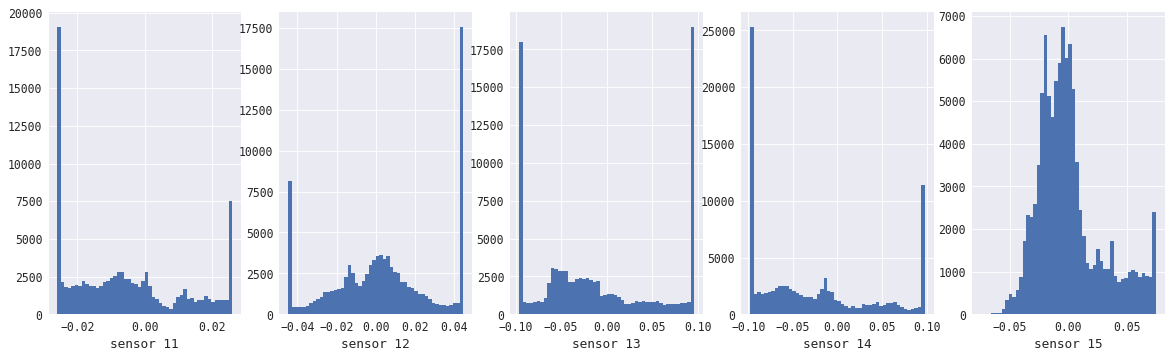

In [18]:
bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,0], bins = bin_num)
plt.xlabel('sensor 1')

plt.subplot(1,5,2)
plt.hist(sensor_array[:,1], bins = bin_num)
plt.xlabel('sensor 2')

plt.subplot(1,5,3)
plt.hist(sensor_array[:,2], bins = bin_num)
plt.xlabel('sensor 3')

plt.subplot(1,5,4)
plt.hist(sensor_array[:,3], bins = bin_num)
plt.xlabel('sensor 4')

plt.subplot(1,5,5)
plt.hist(sensor_array[:,4], bins = bin_num)
plt.xlabel('sensor 5')

plt.show()


bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,5], bins = bin_num)
plt.xlabel('sensor 6')

plt.subplot(1,5,2)
plt.hist(sensor_array[:,6], bins = bin_num)
plt.xlabel('sensor 7')

plt.subplot(1,5,3)
plt.hist(sensor_array[:,7], bins = bin_num)
plt.xlabel('sensor 8')

plt.subplot(1,5,4)
plt.hist(sensor_array[:,8], bins = bin_num)
plt.xlabel('sensor 9')

plt.subplot(1,5,5)
plt.hist(sensor_array[:,9], bins = bin_num)
plt.xlabel('sensor 10')

plt.show()
bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,10], bins = bin_num)
plt.xlabel('sensor 11')

plt.subplot(1,5,2)
plt.hist(sensor_array[:,11], bins = bin_num)
plt.xlabel('sensor 12')

plt.subplot(1,5,3)
plt.hist(sensor_array[:,12], bins = bin_num)
plt.xlabel('sensor 13')

plt.subplot(1,5,4)
plt.hist(sensor_array[:,13], bins = bin_num)
plt.xlabel('sensor 14')

plt.subplot(1,5,5)
plt.hist(sensor_array[:,14], bins = bin_num)
plt.xlabel('sensor 15')

plt.show()

In [20]:
np.mean(env.score_list)

-214.70091282476281